# Check that fits work in all four quadrants
We had a bug report from Vanessa that it did not work in the third and fourth quadrants

## Imports

We need to explictly add the path to the library since we haven't installed it yet.

In [1]:
import time

In [2]:
start_time = time.time()
from pathlib import Path
import sys

In [3]:
sys.path.append("../src")
import confit
import numpy as np
import lmfit
from matplotlib import pyplot as plt
import seaborn as sns

Check that we have the right module

In [4]:
confit?

Type:        module
String form: <module 'confit' from '/Users/will/Dropbox/confit/notebooks/../src/confit.py'>
File:        ~/Dropbox/confit/src/confit.py
Docstring:   Fit conic section curves to data.

## Where to save the figures

In [5]:
figpath = Path.cwd().parent / "figs"
saveprefix = "demo05"

## Test data

I use the same pattern of 7 points as the basis, but we are going to rotate it through different angles to make sure that the fits still work

In [6]:
xpts0, ypts0 = np.array([1, 2, 3, 4, 5, 6, 7]), np.array([0, 4, 6, 7, 6, 4, 0])
ypts0 += xpts0
xpts0 *= 3

## Function to rotate the points

Rotate anticlockwise through an angle theta in degrees

In [7]:
def rotate(x, y, theta):
    c = np.cos(np.deg2rad(theta))
    s = np.sin(np.deg2rad(theta))
    xx = x * c - y * s
    yy = x * s + y * c
    return xx, yy
    

In [8]:
rotate(1, 1, -90)

(1.0, -0.9999999999999999)

Plot the points for 6 different orientations

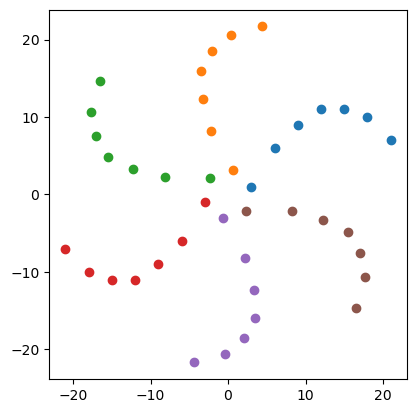

In [9]:
fig, ax = plt.subplots()
for theta in np.arange(6) * 60:
    xpts, ypts = rotate(xpts0, ypts0, theta)
    ax.scatter(xpts, ypts)
ax.set_aspect("equal")
...;

In [10]:
fig.savefig(figpath / f"{saveprefix}-points.pdf", bbox_inches="tight")

## Initial guess at conic parameters

This is done automatically inside the fitting function, but we will do it explicitly so we can see what it is doing

I have added some debug print statements inside of `init_conic_from_xy()` so we can see what is going on. This led to the realization that the problem was with the use of the median for finding the initia focus position. I have switched it to the mean, which seems to have solved the problem. 

In [11]:
theta = 210
xpts, ypts = rotate(xpts0, ypts0, theta)
confit.DEBUG = True
initial_conic = confit.init_conic_from_xy(xpts, ypts)
initial_conic

closest_points=array([3, 2, 4, 1, 5])
r[closest_points]=array([3.14285714, 3.21031501, 4.34483038, 6.28084227, 6.37117232])
np.rad2deg(th[closest_points])=array([ -60.        ,    9.14554196, -103.66778015,   47.19854122,
       -130.34617594])
theta0=306.9268304461369


{'x0': -6.4637334168418334,
 'y0': -12.804485315449162,
 'r0': 4.670003423475774,
 'theta0': 306.9268304461369,
 'eccentricity': 1.0}

Look at the residuals for this initial guess, which is
$$
r - e d
$$
where $r$ is the radius of each point from the focus and $d$ is the distance of each point from the directrix.

We turn on DEBUG so that the residual function will print out the individual vectors, $r$, $d$, and $e \times d$.

In [12]:
initial_params = lmfit.create_params(**initial_conic)
confit.residual(initial_params, xpts, ypts)

r = [11.31461038  6.28084227  3.21031501  3.14285714  4.34483038  6.37117232
  9.04072419]
d = [15.06168383 10.45998409  7.84368631  6.2200895   6.58189464  7.93640075
 11.27630882]
e d = [15.06168383 10.45998409  7.84368631  6.2200895   6.58189464  7.93640075
 11.27630882]


array([-3.74707344, -4.17914182, -4.6333713 , -3.07723235, -2.23706426,
       -1.56522843, -2.23558463])

The residuals are all negative, meaning points are inside the conic. This suggests that `r0` is overestimated.

Turn the `DEBUG` flag back off.

In [13]:
confit.DEBUG = False

In [14]:
init_xy = confit.XYconic(**initial_conic)
print(init_xy)

Conic section curve with focus at (-6.4637334168418334, -12.804485315449162), scale factor 4.670003423475774, angle 306.9268304461369, and eccentricity 1.0.


/Users/will/Dropbox/confit/notebooks/../src/confit.py:131: RuntimeWarning: divide by zero encountered in true_divide
  self.r0


Ellipsis

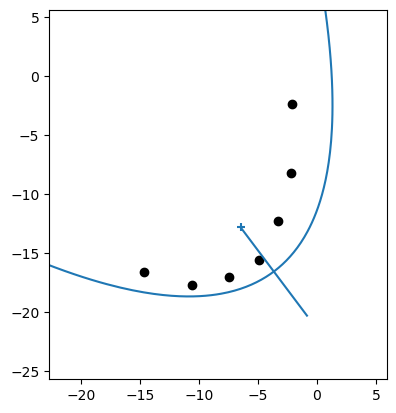

In [15]:
fig, ax = plt.subplots()
ax.scatter(xpts, ypts, color="k")

c = "C0"
ax.plot(init_xy.x_pts, init_xy.y_pts, color=c)
ax.scatter(init_xy.x0, init_xy.y0, marker="+", color=c)
ax.plot([init_xy.x0, init_xy.x_mirror], [init_xy.y0, init_xy.y_mirror], color=c)

ax.set_aspect("equal")
margin = 8
ax.set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
...

## Do the fitting for a range of rotations of the origina data

We make a dictionary with keys of the rotation angles that holds the data points and the two fits (parabola and general conic)

In [16]:
results = {}
for theta in np.arange(6) * 60:
    xpts, ypts = rotate(xpts0, ypts0, theta)
    result_p = confit.fit_conic_to_xy(xpts, ypts, only_parabola=True)
    result_e = confit.fit_conic_to_xy(xpts, ypts, only_parabola=False)
    results[theta] = {
        "x": xpts, 
        "y": ypts,
        "pfit": result_p,
        "efit": result_e,
    }


Look at the residuals:

In [17]:
[result["pfit"].residual for result in results.values()]

[array([-0.02965692,  0.09711228, -0.15980911,  0.20396384, -0.24071297,
         0.20138748, -0.07228459]),
 array([-0.02965547,  0.09711188, -0.15981083,  0.20396269, -0.24071195,
         0.20138874, -0.07228506]),
 array([-0.02965732,  0.09711277, -0.15980821,  0.20396369, -0.24071441,
         0.20138679, -0.0722833 ]),
 array([-0.02965468,  0.09711193, -0.15981145,  0.20396188, -0.24071205,
         0.20138914, -0.07228478]),
 array([-0.02965624,  0.09711233, -0.15980963,  0.20396309, -0.24071313,
         0.20138782, -0.07228425]),
 array([-0.02965432,  0.09711143, -0.15981231,  0.20396205, -0.24071064,
         0.20138982, -0.07228601])]

Those all look the same, which is good. 

Extract all the parameters as a dataframe

In [18]:
import pandas as pd

In [19]:
df = pd.DataFrame(
    {"angle": angle, **result["efit"].params.valuesdict()} 
    for angle, result in results.items()
)
df

,angle,x0,y0,r0,theta0,eccentricity
0,0,14.183694,7.944284,3.242200,87.802589,0.933625
1,60,0.211882,16.255574,3.242193,147.802717,0.933628
2,120,-13.971803,8.311296,3.242197,207.802585,0.933626
3,180,-14.183677,-7.944300,3.242186,267.802770,0.933629
4,240,-0.211886,-16.255581,3.242194,327.802642,0.933627
5,300,13.971799,-8.311276,3.242190,27.802774,0.933629


Now look at the fitted angle minus the data rotation angle

[(0.0, 180.0)]

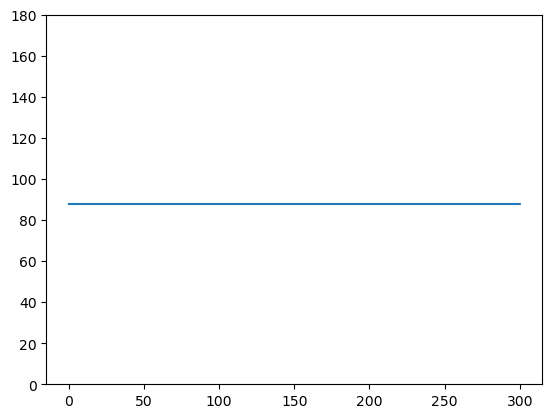

In [20]:
fig, ax = plt.subplots()
ax.plot(df["angle"], (df["theta0"] - df["angle"]) % 360)
ax.set(ylim=[0, 180])

This is constant, which is what we hoped. This show that the fit is the same for all the different data rotation angle. 

## Plotting the best fit onto the data

In [21]:
bestp_xy = confit.XYconic(**result_p.params.valuesdict())
print(bestp_xy)

Conic section curve with focus at (14.107847533118834, -7.974940255933507), scale factor 2.9827104846050414, angle 30.186064225941678, and eccentricity 1.0.


/Users/will/Dropbox/confit/notebooks/../src/confit.py:131: RuntimeWarning: divide by zero encountered in true_divide
  self.r0


In [22]:
beste_xy = confit.XYconic(**result_e.params.valuesdict())
print(beste_xy)

Conic section curve with focus at (13.971799481714019, -8.311275701645181), scale factor 3.242189971560144, angle 27.802773740099674, and eccentricity 0.9336285067208161.


In [23]:
init_xy = confit.XYconic(**initial_conic)
print(init_xy)

Conic section curve with focus at (-6.4637334168418334, -12.804485315449162), scale factor 4.670003423475774, angle 306.9268304461369, and eccentricity 1.0.


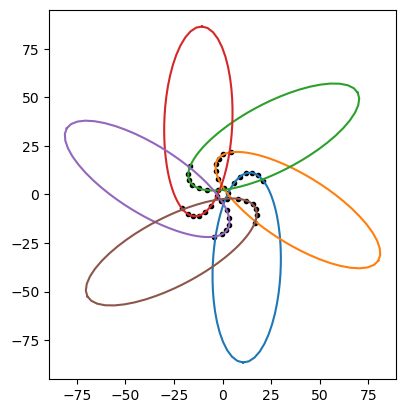

In [24]:
fig, ax = plt.subplots()
for theta, result in results.items():
    beste_xy = confit.XYconic(**result["efit"].params.valuesdict())
    ax.plot(beste_xy.x_pts, beste_xy.y_pts)
    ax.scatter(result["x"], result["y"], marker=".", color="k")
    ax.set_aspect("equal")
...;

In [25]:
fig.savefig(figpath / f"{saveprefix}-best-fits.pdf", bbox_inches="tight")

## Execution time for notebook

In [26]:
print(f"--- {time.time() - start_time} seconds ---")

--- 3.345081090927124 seconds ---
